# A Tutorial on Quantile Regression, Quantile Random Forests, and Quantile GBM
- 이번 태양광 발전량 예측 AI 경진대회의 평가지표로 나온 것인데 공부를 좀 해봅시다.
- 링크: https://medium.com/analytics-vidhya/a-tutorial-on-quantile-regression-quantile-random-forests-and-quantile-gbm-d3c651af7516

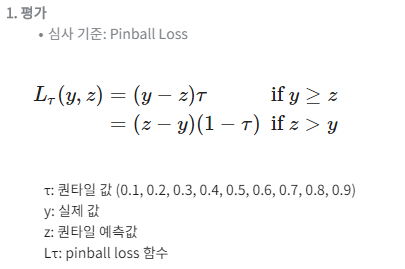

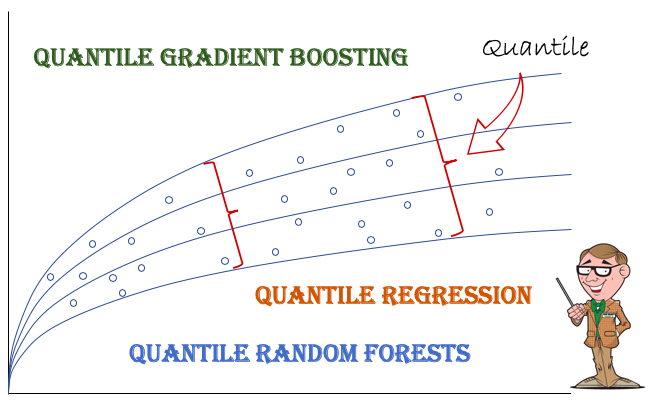

평균 예측 외에 예측 구간(prediction intervals)을 제공하라는 요청을 받으셨습니까? 예측 구간은 더 나은 지침을 제공하기 위해 예측 값의 범위를 제공하기 때문에 많은 사용 사례가 있다. 재무위험관리에서 높은 범위의 예측간격은 위험관리자가 위험을 완화하는 데 도움이 될 수 있다. 과학에서, 100시간에서 110시간 사이의 배터리의 예상 수명은 사용자에게 조치를 취해야 할 시기를 알려줄 수 있다.

어떤 문장을 따르는 것이 더 적절할까?
- 예상 평균 재정 손실은 4천만 달러다.
- 우리는 금융 손실은 1천만 달러에서 7천만 달러 사이가 될 것이라고 95% 신뢰하고 있으며 평균은 4천만 달러 정도 될 것이다. 게다가, 우리는 재정적 손실이 3천만 달러에서 5천만 달러 사이가 될 것이라는 68%의 확신을 가지고 있다.


첫번 째 문장은 첫 번째는 Ordinary Least Square(OLS: 최소제곱법)의 예측이고 두 번째는 Quantile Regression(QR)이다. 이 때문에 QR은 관심이 높아지고 투자, 금융, 경제, 의료, 엔지니어링 등 여러 분야에 적용됐다.

OLS는 오직 조건부 평균인 Y = E[Y|X]+e 만 예측한다. OLS 모델이 조건부 평균을 의미하는 것이면, 조건부 중위수 또는 다른 백분위수를 모형화하는 것이 어떨까(QR에서 quantile은 백분위수(percentile)와 동일하다). QR은 OLS와 비슷한 시기에 발명됐지만, 오늘날의 뛰어난 계산 능력 때문에 인기를 얻게 됐다.

#### QR의 장점은 무엇일까?

QR은 다음과 같은 이유로 매력적이다.
1. QR은 목표 변수의 전체 조건부 분포를 모형화하는 반면 OLS는 평균 추정치만 제공한다.
2. QR은 목표 분포를 가정하지 않기 때문에 오류 분포를 잘못 지정할 경우 더욱 강력하다.
3. QR은 이상치에 민감하지 않다. OLS는 조건부 평균을 추정하기 때문에 이상치에 민감하다.
4. QR은 로그변환과 같이 단조적 변환에 불변하므로, y의 단조 변환인 h(y)의 정량은 h(Qq(y)이며, 그 결과를 y로 되돌리기 위해 역변환을 사용할 수 있다.

랜덤포레스트와 그레디언부스팅과 같은 대다수의 머신러닝 모델들은 오직 평균 예측(점추정 Mean prediction)만 제공한다. 이러한 ML 기법이  정략적 측정을(quantile measures) 제공할 수 있다면 좋지 않을까? 이 게시물에서는 Quantile Regression, Quantile Gradient Boosting, Quantile Random Forests에 대한 단계별 안내를 할 것이다. 

#### 언제 QR을 써야할까?

예측 구간에 관심이 있거나 종속 변수의 분포가 이분산성(heteroscedastic) 경우 QR을 사용하는 것이 좋다.
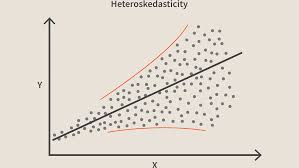

QR은 종속 변수의 분포를 가정하지 않기 때문이다.

Coenker R (2005) Quantile Regression Econometric Society Monographs, Cambridge University의 사례를 나타낸 그림 (A). 고소득(Household Income) 가구에 대한 가계 식량 지출(Household food expenditure)은 훨씬 더 다양하다. OLS는 평균에 대한 예측을 제공하지만 분산 범위를 추정하는 것이 종종 필요하다.
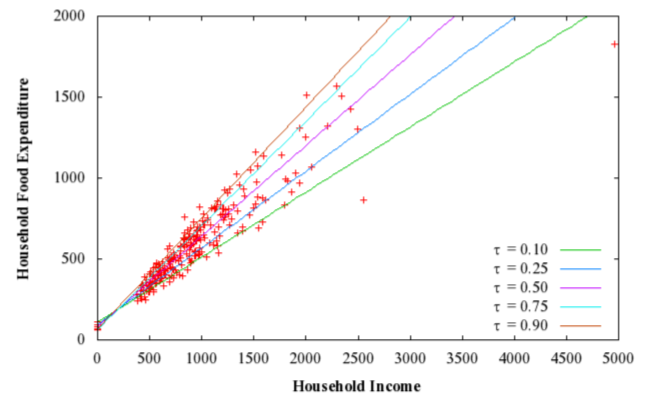

두개의 그래프를 통해 설명해보자. 아래 그림 (A)는 Y의 분산이 그대로 유지되는 경우를 보여주고, 그림 (B)는 X가 증가할수록 Y의 분산이 증가하는 경우를 보여준다. 계량 경제학에서는, 그림(A)를 잔차 항의 분산이 일정하게 유지되는 등분산성이라고 한다. 그림(B)는 분산이 크게 변화하는 이분산성이라고 한다. 대부분의 실제 데이터는 그림(A)보다는 그림(B)에 가깝다. OLS 회귀 분석은 등분산성을 가정한다. 그러므로 QR은 이분산성이 존재할 때 더욱 요긴한 녀석이다.

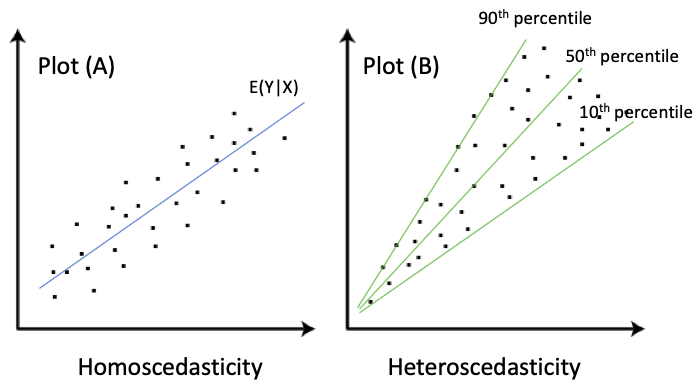

#### 예측구간(Prediction Inteval)은 신뢰구간(Confidence Interval)과 다른 것이다.

QR을 소개하기 이전에, 예측구간과 신뢰구간이 다르고, 예측구간은 신뢰구간보다 넓다는 점을 명확히 하자. 신뢰 구간은 회귀 분석에서 𝜷±1.96 S.E.(iii)와 같은 계수의 범위를 알려준다. 예측 구간은 미래 값이 떨어질 구간을 알려준다.

## Boston Housing Data 예시

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
from sklearn import metrics

%matplotlib inline

from sklearn.datasets import load_boston
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data,columns = boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


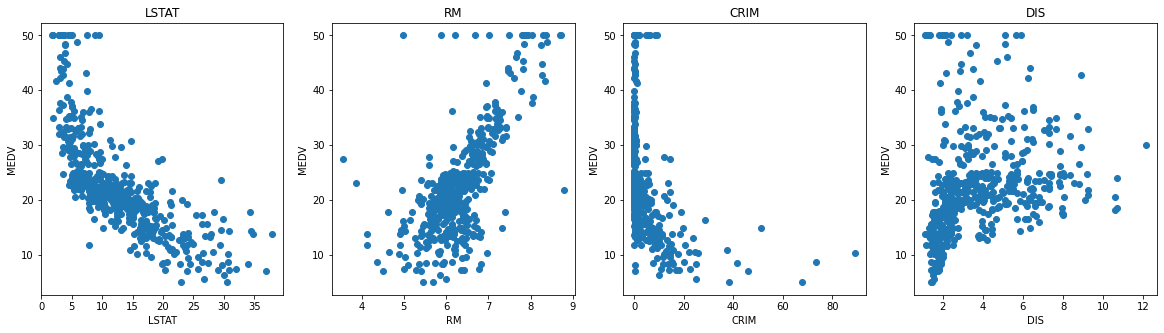

In [9]:
plt.figure(figsize=(20,5))

features = ['LSTAT','RM','CRIM','DIS']
target = boston_dataset.target

for i, col in enumerate(features):
  plt.subplot(1,len(features),i+1)
  x = boston[col]
  y = target
  plt.scatter(x,y,marker='o')
  plt.title(col)
  plt.xlabel(col)
  plt.ylabel("MEDV")

위 그림은 MEDV와 몇 가지 변수 사이의 관계를 보여준다. 몇몇 변수들은 이미 이분산성을 보여준다.

In [11]:
from sklearn import preprocessing
boston = pd.DataFrame(boston_dataset.data,columns = boston_dataset.feature_names)

# Standardize the variables
# 종속변수를 표준화하는 것은 반드시 필요한 것은 아님.
X_scaled = pd.DataFrame(preprocessing.scale(boston))
Y_scaled = preprocessing.scale(boston_dataset.target)
X_scaled.columns = boston.columns

### OLS

사람들은 종종 OLS는 평균을 모델링한다라고 얘기하곤한다. 그것은 조건부 평균으로 공식적으로 명시되어야 한다. 주어진 X=x의 Y의 조건부 평균은 E[Y|X=x]로 정의된다. 아래 코드는 OLS 모델이다. 결정계수가 0.73다. 변수를 내림차순으로 표시해보자. "LSTAT"는 Y의 평균에 가장 큰 영향을 미치고 "RAD", "DIS" 등이 그 뒤를 따른다.

R2 score is 0.73


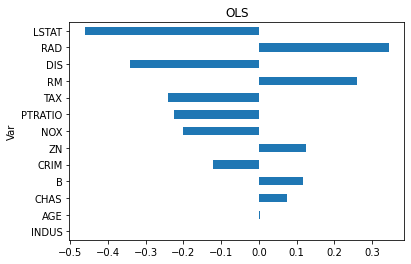

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X_train,X_test,Y_train,Y_test = train_test_split(X_scaled,Y_scaled,test_size = 0.2,random_state=5)

OLS = LinearRegression()
OLS.fit(X_train,Y_train)

# model evaluation for testing set
y_test_predict = OLS.predict(X_test)
r2 = metrics.r2_score(Y_test,y_test_predict).round(2)
print('R2 score is {}'.format(r2))

# Plot the coefficients in descending order
w = pd.DataFrame()
w['Var'] = X_train.columns
w = w.set_index('Var') # Set the variable names as the index
w['beta'] = OLS.coef_
w['beta_abs'] = np.abs(w['beta']) # Get the absolute value for ranking
w = w.sort_values(by = 'beta_abs')
w['beta'].plot.barh()
plt.title('OLS')
#fig.tight_layout()
plt.show()

### Quantile Regression

OLS는  X와 Y의 관계를 부분적으로만 제공한다. 우리는 y의 조건부 분포에서 다양한 지점에서 관계를 설명하는 데 관심이 있을 수 있다. 종속변수의 99%,95%,50%(중앙값),5%,1% 분위수를 알아보자. 5개의 분위수를 나열했기 때문에, 5개의 QR이 있을 것이다. 5개의 다른 모형이 있으므로 변수 계수는 달라야 한다. 그 변수들이 분위수마다 어떻게 다른지 보면 흥미로울 것이다.

모델링을 수행하기 위해 Qreg 함수를 만들고, 하한과 상한으로 계수를 계산하자. 5개 모델의 계수를 Qreg_coefs에 저장한다. 50% 백분위수의 R 제곱 값은 0.75이다.

In [23]:
import statsmodels.regression.quantile_regression as Q_reg

quantiles = [0.01,0.05,0.50,0.95,0.99]

# Get the model, and the coefficients in (a) - (b)
def Qreg(q):
  # (a) Modeling
  mod = Q_reg.QuantReg(Y_train,X_train).fit(q=q)

  # (b) Get the coefficeints and the lower and upper bounds
  coefs = pd.DataFrame()
  coefs['params'] = mod.params
  coefs = pd.concat([coefs,mod.conf_int()],axis=1)
  coefs['q'] =q
  coefs.columns = ['beta','beta_lower','beta_upper','quantile']

  return coefs

Qreg_coefs = pd.DataFrame()
for q in quantiles:
  coefs = Qreg(q)
  Qreg_coefs = pd.concat([Qreg_coefs,coefs])

# Get the R-squared for Q=0.5
q = 0.5
Y_test_pred = Q_reg.QuantReg(Y_train,X_train).fit(q=q).predict(X_test)
r2 = metrics.r2_score(Y_test,Y_test_pred)
print('R2 score is {}'.format(r2)) # 0.75

R2 score is 0.7536284701070775


5개의 QR 모델들의 계수를 막대그래프로 그려보자. 계수들은 내림차순으로 순위를 매기자.

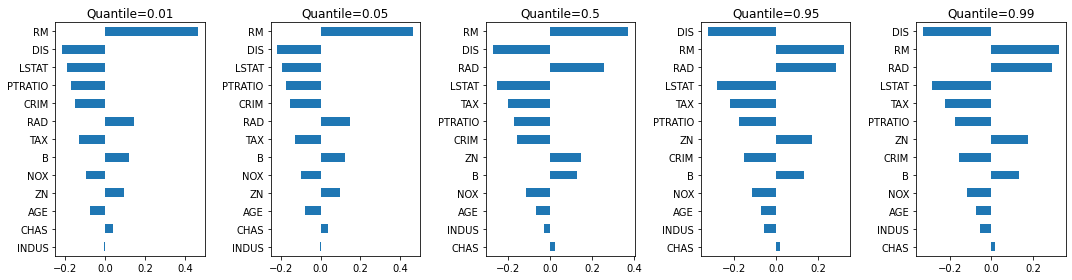

In [27]:
# Get the absolute value of the coefficients for ranking
Qreg_coefs['beta_abs'] = np.abs(Qreg_coefs['beta'])
Qreg_coefs = Qreg_coefs.sort_values(by=['quantile','beta_abs'])

fig = plt.figure(figsize=(15,4))
n = len(quantiles)

for i in range(n):
  plt.subplot(1,n,i+1)
  w = Qreg_coefs[Qreg_coefs['quantile']==quantiles[i]]
  w['beta'].plot.barh()
  plt.title('Quantile=' + str(quantiles[i]))

fig.tight_layout()
plt.show()

각 5개의 분위마다 회귀 모형의 가중치 순위가 달라진 것을 알 수 있다.

### QR(Quantile Regression)은 어떤 원리인 것일까?

QR은 LAD(Last-Absolute-Development)를 사용하여 추정기(estimator)를 얻는다. 어떻게 작동하는지 설명하기 위해 OLS, 그 다음 중위수(Median) 회귀 분석(MR), 그리고 분위수 회귀 분석(QR)으로 확장해보자. 선형 모델 Y = X 𝛃 + e는 오차 제곱 합을 최소화하여 최적의 추정기를 구한다.

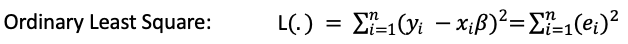

중위수 회귀분석은 절대 편차를 최소화하여 추정기를 얻는다. 최소 절대 편차라고도 불린다. X가 대칭이면 평균과 중위수는 거의 같고 추정치는 OLS와 동일하다.

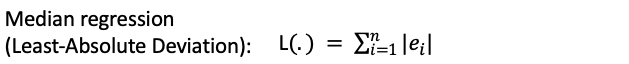

최소 절대 편차(LAD)의 개념은 OLS처럼 간단하다. 그러나 LAD 회귀 분석에는 OLS와 같은 분석적 해결 방법이 없다. 선형 프로그래밍 또는 단순화 방법이 필요하다. 다음 요구 사항을 충족하는 추정기를 검색한다.
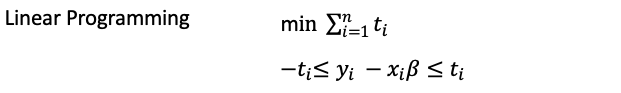

오늘날의 계산 능력은 선형 프로그래밍을 매우 쉽게 만들었다. 나아가, LAD 회귀는 다음과 같은 정량 회귀(QR) 추정기로 확장할 수 있다.

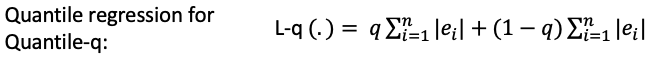

QR 회귀는 비대칭 페널티인 과대예측에 대한 (1 − q)|ei | 과 과소예측에 대한 q|ei | 합을 최소화한다. q=0.50일 때, QR 회귀는 위의 LAD 방정식과 일치하게 된다.

### Quantile GBM

현대의 기계 학습 알고리즘은 정량(Quantile) 개념을 통합했다. Scickit-learn 함수 GradientBoostingRegressor는 loss='quantile'에 의한 quantile modeling을 수행할 수 있으며 매개변수 alpha에 quantile을 할당할 수 있다.

In [29]:
from sklearn.ensemble import GradientBoostingRegressor
quantiles = [0.01, 0.05, 0.50, 0.95 , 0.99]

# Get the model and the predictions in (a) - (b)
def GBM(q):
    
   # (a) Modeling  
   mod = GradientBoostingRegressor(loss='quantile', alpha=q,
                                n_estimators=500, max_depth=8,
                                learning_rate=.01, min_samples_leaf=20,
                                min_samples_split=20)
   mod.fit(X_train, Y_train)

   # (b) Predictions
   pred = pd.Series(mod.predict(X_test).round(2))
   return pred, mod

GBM_models=[]
GBM_actual_pred = pd.DataFrame()

for q in quantiles:
    pred , model = GBM(q)
    GBM_models.append(model)
    GBM_actual_pred = pd.concat([GBM_actual_pred,pred],axis=1)
    
GBM_actual_pred.columns=quantiles
GBM_actual_pred['actual'] = Y_test
GBM_actual_pred['interval'] = GBM_actual_pred[np.max(quantiles)] - GBM_actual_pred[np.min(quantiles)]
GBM_actual_pred = GBM_actual_pred.sort_values('interval')

GBM 모델은 1%, 5%, 50%, 95%, 99% 5가지로 제작되었다. 또한, 5개의 모델마다 변수 중요도가 다른 것을 볼 수 있다.

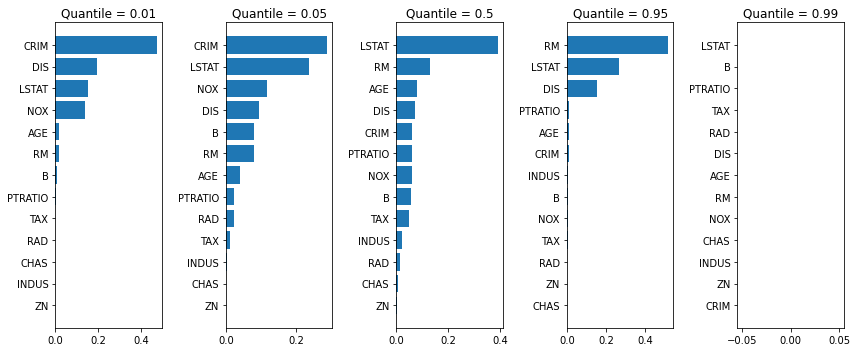

In [30]:
fig = plt.figure(figsize=(12, 5))

n = len(quantiles)

for i in range(n):
    plt.subplot(1, n, i+1)
    feature_importance = GBM_models[i].feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(boston.columns)[sorted_idx])
    plt.title('Quantile = ' + str(quantiles[i] ))

fig.tight_layout()
plt.show()

다음 코드는 또한 R-제곱이 OLS의 0.73과 Quantile 회귀 분석의 0.75와 비교하여 0.89임을 보여준다.

In [31]:
r2 = metrics.r2_score(GBM_actual_pred['actual'], GBM_actual_pred[0.5]).round(2)
print('R2 score is {}'.format(r2) ) # 0.89
GBM_actual_pred

R2 score is 0.89


,0.01,0.05,0.5,0.95,0.99,actual,interval
82,-1.09,-0.77,-0.54,0.19,2.99,-0.090641,4.08
18,-1.09,-0.85,-0.53,0.15,2.99,-0.308315,4.08
0,-1.11,-0.20,2.38,2.98,2.99,1.639875,4.10
68,-1.11,-0.36,-0.14,0.21,2.99,-0.090641,4.10
67,-1.11,-0.18,0.16,0.44,2.99,0.235872,4.10
...,...,...,...,...,...,...,...
5,-1.70,-1.71,-1.51,0.13,2.99,-1.320504,4.69
19,-1.70,-1.18,-0.24,2.61,2.99,-0.819852,4.69
46,-1.72,-1.81,-1.59,0.13,2.99,-1.690551,4.71
37,-1.72,-1.69,-1.57,0.14,2.99,-1.549063,4.71


위의 데이터프레임은 GBM_actual_pred의 몇 가지 예시이다. 대부분의 실제 값은 1%와 99% 구간 안에 들어갈 것으로 예상된다. 우리가 그것을 증명할 수 있을까?

실제 값의 대부분이 1%와 99% 구간 안에 들어가는가? 그래프에는 예측 구간과 실제 값이 표시된다.

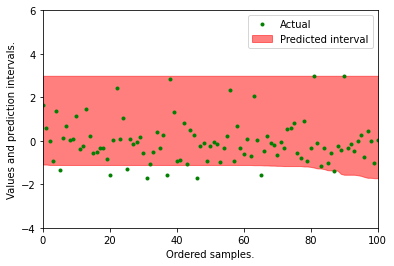

In [32]:
def showIntervals(df):    
    plt.plot(df['actual'],'go',markersize=3,label='Actual')
    plt.fill_between(
        np.arange(df.shape[0]), df[0.01], df[0.99], alpha=0.5, color="r",
        label="Predicted interval")
    plt.xlabel("Ordered samples.")
    plt.ylabel("Values and prediction intervals.")
    plt.xlim([0, 100])
    plt.ylim([-4, 6])
    plt.legend()
    plt.show()
    
showIntervals(GBM_actual_pred)

측 결과를 측정하는 또 다른 방법은 구간 내에 포함되는 관측치의 수를 세는 것이다. 다음 함수는 97.05%를 얻는다.

In [33]:
def correctPcnt(df):
    correct = 0
    obs = df.shape[0]
    for i in range(obs):
        if df.loc[i,0.01] <= df.loc[i,'actual'] <= df.loc[i,0.99]:
            correct += 1
    print(correct/obs)
    
correctPcnt(GBM_actual_pred) # The result is 0.9607

0.9705882352941176


### Quantile Random Forests

표준 랜덤 포리스트는 반응 변수의 조건부 평균에 대한 정확한 근사치를 제공한다. [니콜라이 마인슈센(2006)](https://www.jmlr.org/papers/volume7/meinshausen06a/meinshausen06a.pdf)은 조건부 평균뿐만 아니라 반응 변수의 완전한 조건부 분포를 위한 정보를 제공하기 위해 표준 랜덤포레스트를 일반화한다. 따라서 QR Forests는 고차원 예측 변수에 대한 조건부 계량형 추정의 비모수적이고 정확한 방법을 제공한다.

어떤 원리일까? 표준 랜덤 포레스트 모델은 각 트리 잎에 있는 종속 변수의 평균값을 계산한다. 잎(leaf)에 있는 모든 관측치들을 기록하면, 분위수를 계산할 수 있다. 랜덤 포레스트 모델에서 입력 관측치에 대해 100개의 예측 값을 생성하는 100개의 트리가 있다고 가정해보자. 표준 랜덤 포레스트는 100개의 예측 값의 평균을 취함으로써 조건부 평균을 얻는다. 이를 확장하여 전체 분포와 신뢰 구간을 얻을 수 있다.

이 접근방식은 GBM과는 달리 5개의 분량 랜덤 포레스트 모델을 구축하지 않는다. 이 방법은 예측에 대한 신뢰 구간을 계산하기 위해 하나의 랜덤 포레스트 모델을 구축한다. Quantile GBM과는 달리, 각 분위수에서 다양한 변수 순위를 볼 수 없고, 여전히 예측 간격을 전달할 수 있다.

200개의 Tree를 만들자. 랜덤 포레스트 모델을 "포장하지 않으면서" 200개의 개별 나무의 예측을 기록한다. 200개의 tree 모델은 Input 값에 맞게 200개의 예측치를 만들고 이를 200개의 컬럼으로 만들자. 나무 개수에 따라 시간이 얼마나 걸릴지 정해진다. 

In [34]:
# random forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, random_state=0,min_samples_split=10)
rf.fit(X_train, Y_train)

# Get the predictions of all trees for all observations
# Each observation has N predictions from the N trees
pred_Q = pd.DataFrame()
for pred in rf.estimators_:
    temp = pd.Series(pred.predict(X_test).round(2))
    pred_Q = pd.concat([pred_Q,temp],axis=1)
pred_Q.head()

,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,2.87,2.99,2.39,2.40,2.91,2.76,2.52,2.80,2.56,2.60,2.52,2.37,2.91,2.53,2.82,2.85,2.58,2.26,2.81,2.76,2.27,2.32,2.23,2.99,2.39,2.36,2.90,2.99,2.99,2.48,2.90,2.51,2.66,2.88,2.58,2.80,2.29,2.90,2.99,2.94,...,2.89,2.95,2.11,2.32,2.76,2.56,2.61,2.46,2.93,2.99,2.88,2.49,2.12,2.53,2.40,2.67,2.88,2.19,2.89,2.82,2.46,2.27,2.05,2.87,2.61,2.59,2.24,2.53,2.78,2.58,2.20,2.24,2.28,2.56,2.99,1.96,2.99,2.90,2.44,2.61
1,0.48,0.39,0.16,1.04,0.39,0.56,0.42,0.65,1.38,0.93,0.89,0.57,0.18,0.06,0.46,0.60,0.14,0.82,0.81,0.81,1.14,0.17,0.43,0.18,0.65,0.58,0.42,0.84,0.97,0.72,0.76,0.51,0.08,0.33,0.57,0.73,0.48,0.86,0.78,0.11,...,0.82,0.62,0.43,0.97,0.17,0.46,0.91,0.41,0.22,0.21,0.35,0.84,0.49,0.12,0.73,0.87,0.64,0.97,0.56,0.54,0.74,0.68,0.71,0.71,0.43,0.56,0.17,0.14,0.57,0.22,0.86,0.38,0.86,0.70,1.06,0.73,0.71,0.62,1.08,0.09
2,-0.02,0.02,0.11,-0.08,0.06,0.10,0.12,0.11,-0.07,-0.06,-0.12,0.11,0.23,-0.09,0.01,0.01,-0.09,0.04,0.03,-0.08,-0.19,0.11,-0.00,0.06,-0.05,0.06,0.08,0.12,-0.12,0.02,-0.07,0.08,0.19,0.13,-0.10,-0.01,0.02,0.47,-0.02,0.07,...,0.16,-0.02,0.00,0.17,-0.04,-0.12,-0.05,0.05,0.16,0.34,-0.02,-0.22,0.13,-0.15,0.11,0.03,-0.13,0.04,0.10,0.03,-0.11,-0.10,0.01,0.01,0.14,-0.06,-0.11,-0.01,-0.06,0.13,-0.02,0.29,-0.01,0.06,0.10,0.22,-0.03,0.31,0.09,0.14
3,-1.18,-0.95,-1.29,-1.23,-1.31,-0.95,-1.04,-1.05,-1.36,-1.56,-1.55,-0.83,-1.32,-1.12,-1.09,-1.64,-1.65,-0.99,-1.08,-1.74,-0.74,-1.31,-0.36,-1.50,-1.04,-1.67,-1.01,-1.31,-0.97,-0.81,-1.60,-0.96,-1.77,-1.60,-1.33,-1.66,-1.33,-1.43,-1.22,-1.09,...,-1.04,-0.95,-0.86,-1.64,-0.95,-1.21,-1.14,-0.85,-1.01,-1.62,-1.66,-1.60,-1.66,-1.04,-1.57,-1.57,-1.66,-0.86,-1.01,-1.04,-1.03,-1.12,-1.71,-1.12,-0.96,-0.93,-1.56,-1.33,-0.84,-1.15,-0.98,-0.72,-1.74,-1.68,-1.10,-1.20,-1.62,-1.03,-1.01,-1.09
4,2.47,1.31,2.08,2.40,2.32,2.34,2.00,1.84,0.99,2.96,2.35,2.37,2.44,1.30,2.17,2.51,1.29,2.26,1.04,1.51,2.27,2.91,2.23,2.74,2.39,2.36,2.44,2.51,2.58,2.06,2.15,2.61,2.06,2.33,1.36,2.37,2.29,2.19,1.66,2.61,...,2.89,2.39,2.11,2.32,2.76,2.56,2.61,1.82,1.76,1.49,2.19,2.49,2.12,2.96,2.40,2.96,2.36,2.19,1.90,0.19,0.43,2.27,2.05,2.87,2.35,1.84,2.24,2.53,2.26,0.97,2.20,1.36,2.28,2.56,1.18,2.52,1.05,2.25,2.44,2.61


각 관측치(행)에 대한 예측 구간을 얻는 방법은 무엇일까? **바로 열별로 백분위수 통계를 계산하는 것이다.**
- 쉽게 생각하면 각 row의 중앙값을 뽑는다고 생각하면됨. axis가 1이라는 점을 유의하는 것이 좋을 것 같음.

     0.01  0.05   0.5  0.95  0.99  actual  interval
11  -0.46 -0.40 -0.28  0.00  0.15   -0.38      0.61
100 -0.46 -0.41 -0.18  0.00  0.17    0.05      0.63
27  -0.50 -0.44 -0.32  0.01  0.13   -0.15      0.63
5   -1.80 -1.75 -1.61 -1.39 -1.15   -1.32      0.65
26  -0.06  0.01  0.16  0.31  0.61    0.06      0.67
..    ...   ...   ...   ...   ...     ...       ...
74  -1.05 -0.84  2.99  2.99  2.99    0.58      4.04
33  -1.32 -1.07 -0.72  2.99  2.99   -0.52      4.31
92  -1.33 -0.83 -0.21  0.00  2.99   -0.12      4.32
19  -1.34 -1.17 -0.00  2.99  2.99   -0.82      4.33
73  -1.50 -1.36 -0.82  2.99  2.99    0.54      4.49

[102 rows x 7 columns]
R2 score is 0.81
0.9509803921568627


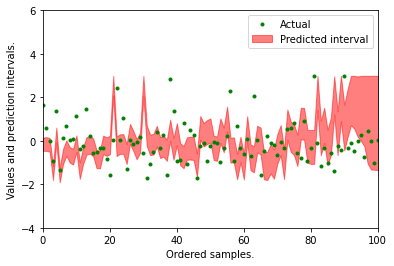

In [65]:
RF_actual_pred = pd.DataFrame()

for q in quantiles:
    s = pred_Q.quantile(q=q, axis=1)
    RF_actual_pred = pd.concat([RF_actual_pred,s],axis=1,sort=False)
   
RF_actual_pred.columns=quantiles
RF_actual_pred['actual'] = Y_test
RF_actual_pred['interval'] = RF_actual_pred[np.max(quantiles)] - RF_actual_pred[np.min(quantiles)]
RF_actual_pred = RF_actual_pred.sort_values('interval')
RF_actual_pred = RF_actual_pred.round(2)
print(RF_actual_pred)

# Get the R-squared
r2 = metrics.r2_score(RF_actual_pred['actual'], RF_actual_pred[0.5]).round(2)
print('R2 score is {}'.format(r2) )  # 0.81

# Get the correct percentage
correctPcnt(RF_actual_pred) # 0.9509

# Show the intervals
showIntervals(RF_actual_pred) 